## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### 之前做過的處理

In [2]:
# 設定 data_path
dir_data = './data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# also apply to testing dataset
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# absolute the value of DAYS_BIRTH
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

***

In [5]:
app_train['AMT_INCOME_TOTAL_cut'] = pd.cut(app_train['AMT_INCOME_TOTAL'], 10)

In [6]:
app_train['AMT_INCOME_TOTAL_cut'].value_counts()

(-91324.35, 11723085.0]       307508
(11723085.0, 23420520.0]           2
(105302565.0, 117000000.0]         1
(93605130.0, 105302565.0]          0
(81907695.0, 93605130.0]           0
(70210260.0, 81907695.0]           0
(58512825.0, 70210260.0]           0
(46815390.0, 58512825.0]           0
(35117955.0, 46815390.0]           0
(23420520.0, 35117955.0]           0
Name: AMT_INCOME_TOTAL_cut, dtype: int64

由上可知AMT_INCOME_TOTAL受到極端值影響較重，可以看一下該欄位的數值分布。

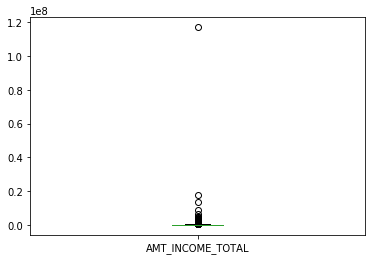

In [7]:
app_train['AMT_INCOME_TOTAL'].plot(kind='box')

In [9]:
app_train['AMT_INCOME_TOTAL'].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

所以要畫此張圖用qcut會較合適

In [27]:
app_train['AMT_INCOME_TOTAL_qcut'] = pd.qcut(app_train['AMT_INCOME_TOTAL'], 10)

In [28]:
app_train['AMT_INCOME_TOTAL_qcut'].value_counts()

(112500.0, 135000.0]       48849
(180000.0, 225000.0]       44809
(99000.0, 112500.0]        36907
(25649.999, 81000.0]       33391
(147150.0, 162000.0]       31120
(162000.0, 180000.0]       30704
(81000.0, 99000.0]         30280
(270000.0, 117000000.0]    27161
(225000.0, 270000.0]       19957
(135000.0, 147150.0]        4333
Name: AMT_INCOME_TOTAL_qcut, dtype: int64

In [12]:
import seaborn as sns

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

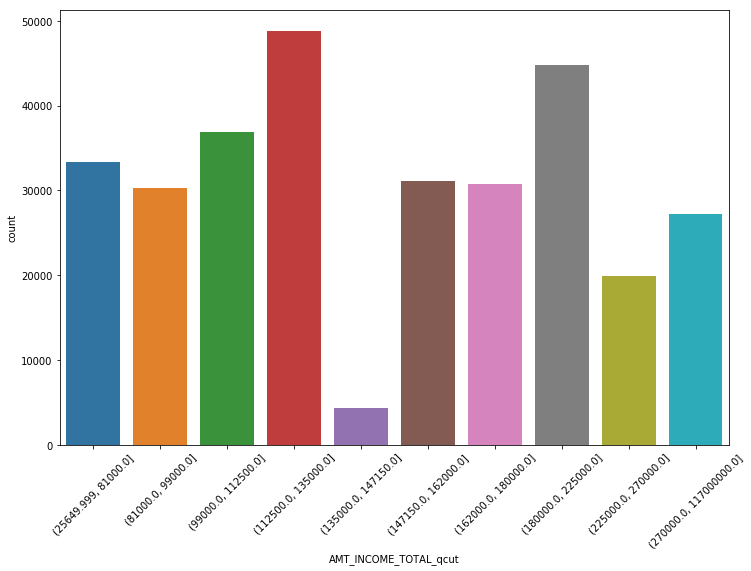

In [22]:
fig= plt.figure(figsize = (12,8))
sns.countplot(app_train['AMT_INCOME_TOTAL_qcut'])
plt.xticks(rotation = 45)
plt.tight_layout

有意思的是Q40-Q50的人數極少，相對於其他的Quantile區間明顯有問題。有可能的原因在重複金額135000的這群人個數很多，導致被劃分在前一個quantile。

C:\Users\Jude\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


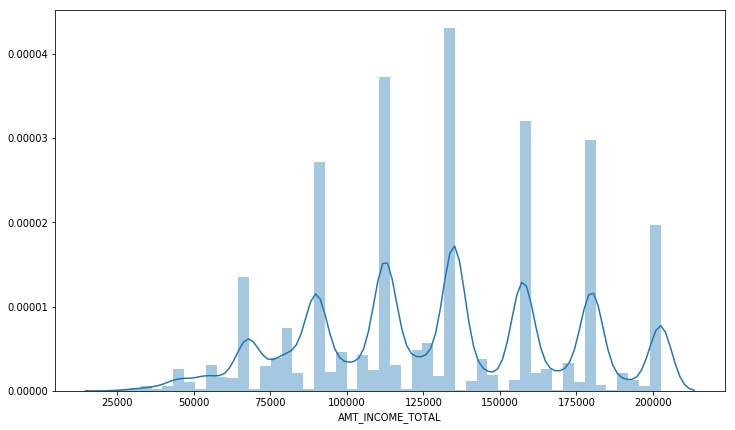

In [40]:
plt.figure(figsize=(12,7))
sns.distplot(app_train.loc[app_train['AMT_INCOME_TOTAL'] <=202500, 'AMT_INCOME_TOTAL'])

從上圖檢查後可以發現AMT_INCOME_TOTAL是有規律存在的。